In [10]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from IPython.display import display, Markdown, clear_output

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# Plot setup
matplotlib.rc('font', size=22, family='normal', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]
np.printoptions(suppress=True)

# Lots of functions piped from Bernstein's C code:

In [11]:
'''Here are some functions piped from Bernstein's transform.c, part of orbfit'''

ECL = np.radians(23.43928)

def check_latlon0(lat0, lon0):
    '''
    This function is adapted from Bernstein's transform.c, part of orbfit.
    It doesn't actually check anything here, just calculates all the sines and cosines.
    '''
    clat0 = np.cos(lat0)
    slat0 = np.sin(lat0)
    clon0 = np.cos(lon0)
    slon0 = np.sin(lon0)
    
    return clat0, slat0, clon0, slon0

def ec_to_proj(lat_ec, lon_ec, lat0, lon0):
    '''
    First routine goes from ecliptic lat/lon to projected x/y angles
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)
    cdlon = np.cos(lon_ec - lon0)
    sdlon = np.sin(lon_ec - lon0)
    clat  = np.cos(lat_ec)
    slat  = np.sin(lat_ec)

    xp = clat * sdlon
    yp = clat0*slat - slat0*clat*cdlon
    zp = slat0*slat + clat0*clat*cdlon

    x_proj = xp/zp
    y_proj = yp/zp

    return x_proj, y_proj


def proj_to_ec(x_proj, y_proj, lat0, lon0):
    '''
    Now the inverse, from projected xy to ecliptic lat/lon
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    zp = 1./np.sqrt(1 + x_proj*x_proj + y_proj*y_proj)
    lat_ec = np.arcsin( zp* (slat0 + y_proj*clat0) )
    lon_ec = lon0 + np.arcsin( x_proj * zp / np.cos(lat_ec) )

    return lat_ec, lon_ec

def xyz_ec_to_proj(x_ec, y_ec, z_ec, lat0, lon0):
    '''
    Next go from x,y,z in ecliptic orientation to x,y,z in tangent-point orientiation.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    x_p = -slon0 * x_ec + clon0 * y_ec
    y_p = -clon0*slat0*x_ec - slon0*slat0*y_ec + clat0*z_ec
    z_p =  clon0*clat0*x_ec + slon0*clat0*y_ec + slat0*z_ec

    return x_p, y_p, z_p

def eq_to_ec(ra_eq, dec_eq):
    '''
    First takes RA,DEC in equatorial to ecliptic.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    se = np.sin(ECL)
    ce = np.cos(ECL)
    sd = ce * np.sin(dec_eq) - se * np.cos(dec_eq)*np.sin(ra_eq)
    lat_ec = np.arcsin(sd)

    y = ce*np.cos(dec_eq)*np.sin(ra_eq) + se*np.sin(dec_eq)
    x = np.cos(dec_eq)*np.cos(ra_eq)
    lon_ec = np.arctan2(y,x)

    return lat_ec, lon_ec

def ec_to_eq(lat_ec, lon_ec):
    '''
    And transform x,y,z from eq to ecliptic.
    
    To reverse above, just flip sign of ECL effectively.
    '''
    se = np.sin(-ECL)
    ce = np.cos(ECL)

    sd = ce * np.sin(lat_ec) - se * np.cos(lat_ec)*np.sin(lon_ec)
    dec_eq = np.arcsin(sd)

    y = ce*np.cos(lat_ec)*np.sin(lon_ec) + se*np.sin(lat_ec)
    x = np.cos(lat_ec)*np.cos(lon_ec)
    ra_eq = np.arctan2(y,x)

    return ra_eq, dec_eq

# New functions I actually wrote:

In [12]:
def get_heliocentric_ecliptic_XYZ_from_JPL(times, obs_code='500',
                                           verbose=False):
    '''
    Query horizons for the ECLIPTIC heliocentric
    observatory position at a sequence of times.

    input:
    obs_code    - string
                - Note that Horizons uses some weird ones sometimes,
                  like "500@-95" for Tess.
    times       - array of JD times (UTC)
    '''
    from astroquery.jplhorizons import Horizons
    times_AP = Time(times, format='jd', scale='utc')
    # convert times to tdb, the time system used by Horizons for vectors. 
    times_tdb = times_AP.tdb.value
    horizons_query = Horizons(id='10', location=obs_code,
                              epochs=times_tdb, id_type='id')
    horizons_vector = horizons_query.vectors(refplane='ecliptic')
    helio_OBS_ecl = 0 - np.array([horizons_vector['x'], horizons_vector['y'],
                                  horizons_vector['z']]).T
    if verbose:
        print('No verbosity implemented yet, sorry')
    return helio_OBS_ecl

def abg2theta(timesJD, timeJD0, abg, obscode, xyz_E, GM=c.GM_sun.to('au**3/year**2').value):
    '''
    Converts input abg to a theta vector at time dtime from reference time.
    inputs:
    -------
    abg    - array length 6 - array containing alpha, beta, gamma,
                              alpha-dot, beta-dot, gamma-dot.
    timesJD - float - times in Julian days
    '''
    # convert times to YEARS since reference time, accounting for light travel time
    light_travel_time = (1/abg[2] * (u.au/c.c).to(u.yr)).value
    dtime = (timesJD - timeJD0) * u.day.to(u.yr) - light_travel_time
    # Calculate gravitational effect
    acc_z = - GM * abg[2] ** 2
    grav_x, grav_y, grav_z = 0, 0, 0.5 * acc_z * dtime ** 2
    # XYZ of observer:
    x_E, y_E, z_E = xyz_E.T
    
    num_x = abg[0] + abg[3] * dtime + abg[2] * grav_x - abg[2] * x_E
    num_y = abg[1] + abg[4] * dtime + abg[2] * grav_y - abg[2] * y_E
    denominator = 1 + abg[5] * dtime + abg[2] * grav_z - abg[2] * z_E
    theta_x = num_x / denominator                       # eq 6
    theta_y = num_y / denominator                       # eq 6
    #theta_x = abg[0] + abg[3] * dtime - abg[2] * x_E   # eq 16
    #theta_y = abg[1] + abg[4] * dtime - abg[2] * y_E   # eq 16
    return np.array([theta_x, theta_y]).T

# Initial conditions and expected values:

In [13]:
'''
Setting some initial conditions for transforming 2015 RS281.
These were obtained using Bernstein's fit_radec and an obs80 file that includes 
a measurement of the first observation as the first line (making it reference time & direction).
    K15RS1S  C2016 08 27.36490 00 41 35.095+06 39 14.91                     568
Full obs file in shifty/dev_data/K15RS1S.obs
'''
abg = np.array([0.00000984, -0.00001155, 0.02301338,            # alpha, beta, gamma
                0.01409909, -0.01679783, 0.00000000])           # a-dot, b-dot, g-d
time0 = 2457626.868610                                          # Reference time
latlon0 = np.radians([2.0088828, 12.1771580])                   # Reference latitude & longitude, radians
print(latlon0)

[0.03506162 0.2125315 ]


In [14]:
'''
These are the times in the shifty/dev_data/K15RS1S.obs file, and below are the thetas printed by
fit_radec < shifty/dev_data/K15RS1S.obs '''
times_str = ['2016 08 26.36861', '2016 08 26.38440', '2016 08 26.40924', '2016 08 26.43305', '2016 08 26.45707',
             '2016 08 26.48136', '2016 08 26.53093', '2016 08 26.55626', '2016 08 26.58106', '2016 08 26.60528',
             '2016 08 26.63031', '2016 08 27.36493', '2016 08 27.38069', '2016 08 27.40521', '2016 08 27.42903',
             '2016 08 27.45310', '2016 08 27.47736', '2016 08 27.57675', '2016 08 27.60094', '2016 08 27.62583']
ymd = np.genfromtxt(times_str)
years = ymd[:, 0].astype(int)
months = ymd[:, 1].astype(int)
dd = ymd[:, 2]
days = dd.astype(int)
hh = (dd - days) * 24
hours = hh.astype(int)
mm = (hh - hours) * 60
minutes = mm.astype(int)
seconds = (mm - minutes) * 60
years, months, days, hours, minutes, seconds
times = Time({'year':years, 'month':months, 'day':days, 'hour':hours, 'minute':minutes, 'second':seconds}).mjd+2400000.5
times_tst = times.copy()
# Thetas from fit_radec:
expected_fitradec = np.array([[0.000, 0.000], [-0.704, -0.135], [-2.252, -0.346], [-3.620, -0.523], [-4.953, -0.609],
                              [-6.499, -0.821], [-9.066, -1.141], [-10.612, -1.352], [-11.984, -1.530], [-13.394, -1.799],
                              [-14.862, -1.828], [-55.906, -7.730], [-56.751, -7.805], [-58.158, -8.075], [-59.533, -8.252],
                              [-60.862, -8.339], [-62.273, -8.608], [-68.029, -9.202], [-69.400, -9.379], [-70.853, -9.739]])

In [15]:
'''
Get the EXPECTED shifts from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
# Query for reference time:
horizons_query0 = Horizons(id='2015 RS281', location='568', epochs=time0, id_type='smallbody')
horizons_ephem0 = horizons_query0.ephemerides(extra_precision=False)
# Query for whole array of times:
horizons_query = Horizons(id='2015 RS281', location='568', epochs=times, id_type='smallbody')
horizons_ephem = horizons_query.ephemerides(extra_precision=False)

latlon_expected = np.array(eq_to_ec(np.radians(horizons_ephem['RA']), np.radians(horizons_ephem['DEC']))).T
thetas_horizons = np.array(ec_to_proj(*latlon_expected.T, *latlon0)).T
thetas_horizons_asec = np.degrees(thetas_horizons) * 3600

# Now calculate thetas from abg:

In [16]:
'''
Get the ecliptic position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

In [17]:
'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected, GM=c.GM_sun.to('au**3/year**2').value)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


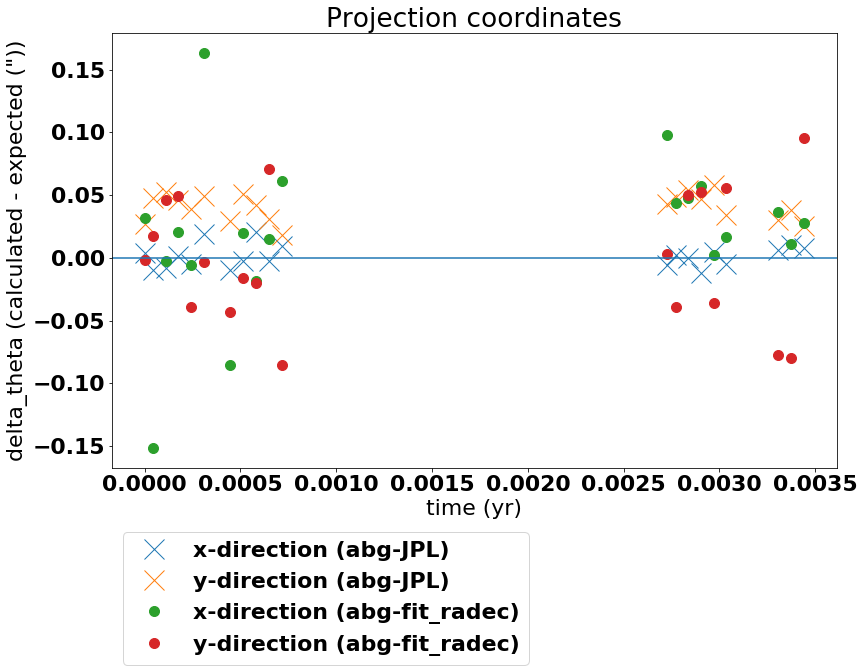

In [18]:
plt.rcParams['figure.figsize'] = [13, 8]
dtimes_yr = (times-time0) * u.day.to(u.yr)
plt.plot(dtimes_yr, (thetas_asec - thetas_horizons_asec)[:, 0], 'x', label='x-direction (abg-JPL)', ms=20)
plt.plot(dtimes_yr, (thetas_asec - thetas_horizons_asec)[:, 1], 'x', label='y-direction (abg-JPL)', ms=20)
plt.plot(dtimes_yr, (thetas_asec - expected_fitradec)[:, 0], '.', label='x-direction (abg-fit_radec)', ms=20)
plt.plot(dtimes_yr, (thetas_asec - expected_fitradec)[:, 1], '.', label='y-direction (abg-fit_radec)', ms=20)
plt.axhline(0)
plt.ylabel('expected - calculated (")')
plt.ylabel('delta_theta (calculated - expected ("))')
plt.xlabel('time (yr)')
plt.title('Projection coordinates')
plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))

In [19]:
# Convert thetas to RA & Dec. 
'''
Get the EXPECTED shifts from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
horizons_query = Horizons(id='2015 RS281', location='568', epochs=times, id_type='smallbody')
horizons_radec = horizons_query.ephemerides(extra_precision=False)
horizons_query0 = Horizons(id='2015 RS281', location='568', epochs=time0, id_type='smallbody')
horizons_radec0 = horizons_query0.ephemerides(extra_precision=False)
# extra_precision=True would be better, but JPL recently broke astroquery.
shift_expected_RA = (horizons_radec['RA'] - horizons_radec0['RA']) * 3600 * np.cos(np.radians(horizons_radec['DEC']))
shift_expected_Dec = (horizons_radec['DEC'] - horizons_radec0['DEC']) * 3600
shift_expected_RADEC_asec = np.array([shift_expected_RA, shift_expected_Dec]).T

Text(0, 0.5, 'Dec residual (From ABG - Horizons)')

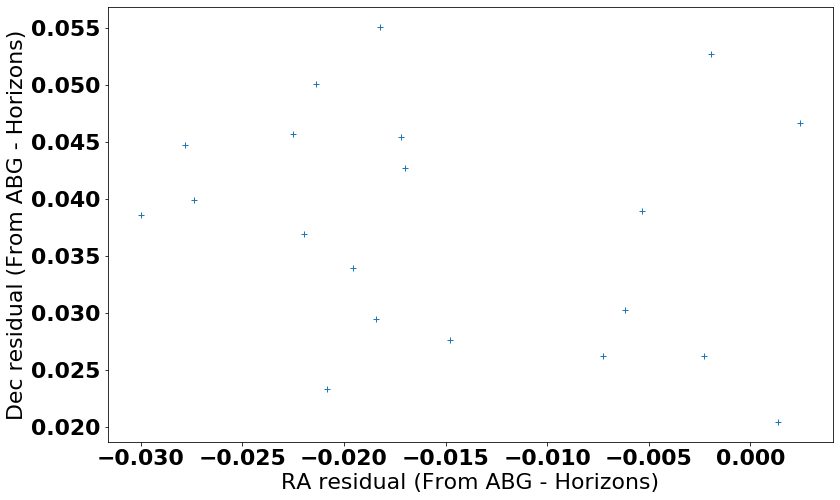

In [21]:
ec_from_abg = proj_to_ec(thetas[:, 0], thetas[:, 1], *latlon0)
radec_from_abg = np.degrees(ec_to_eq(*ec_from_abg))
plt.plot((radec_from_abg[0]-horizons_radec['RA'])*3600, (radec_from_abg[1]-horizons_radec['DEC'])*3600, '+')
plt.xlabel('RA residual (From ABG - Horizons)')
plt.ylabel('Dec residual (From ABG - Horizons)')

In [22]:
np.degrees(np.radians(23.43928))*3600
np.degrees((84381.448*(1./3600)*np.pi/180.))

23.439291111111114

# Shift+stack stuff!

In [23]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
importlib.reload(imagehandler)
# This just defines 24 filenames: 
# 2015RS281_HSC20160825_100.fits to 2015RS281_HSC20160825_111.fits and 
# 2015RS281_HSC20160826_112.fits to 2015RS281_HSC20160826_123.fits,
# without just having them all pasted in here: 
filenames=['../dev_data/2015RS281_HSC20160826_112.fits'.replace('112', str(i)) for i in np.arange(100, 124)]
filenames[:12]=[filenamei.replace('0826', '0825') for filenamei in filenames[:12]]

### Reference: Shift+stack using shifts from Horizons

Combining images using median stacking.


Peak count $\pm$ noise = 55.8 $\pm$  4.1 (13.7$\sigma$)

Saving to file stack.fits
Done!


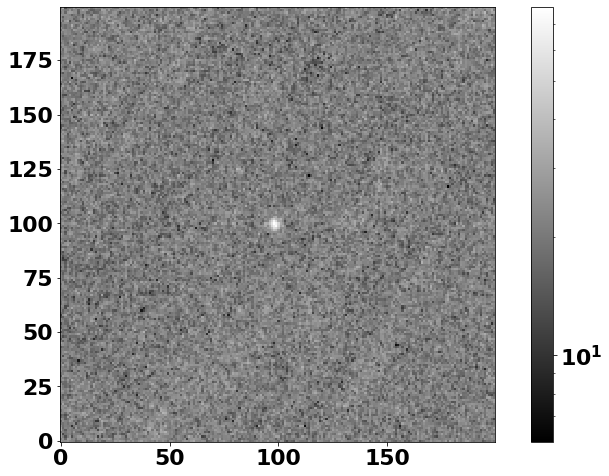

In [24]:
'''
Get times and shifts (as calculated by Horizons)
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, verbose=False, **{'EXPUNIT':'s'})
shiftss = D._calculate_shifts_from_known(object_name='2015 RS281', obs_code='568')
shifts = shiftss - shiftss[12]  # Because image 13 (first image on second night) is the reference time. 
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[520:720,405:605]-np.nanmedian(D.stacked_data.data[520:720,405:605]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))
D.save_stack('stack.fits')

Text(0, 0.5, 'Dec relative to reference time')

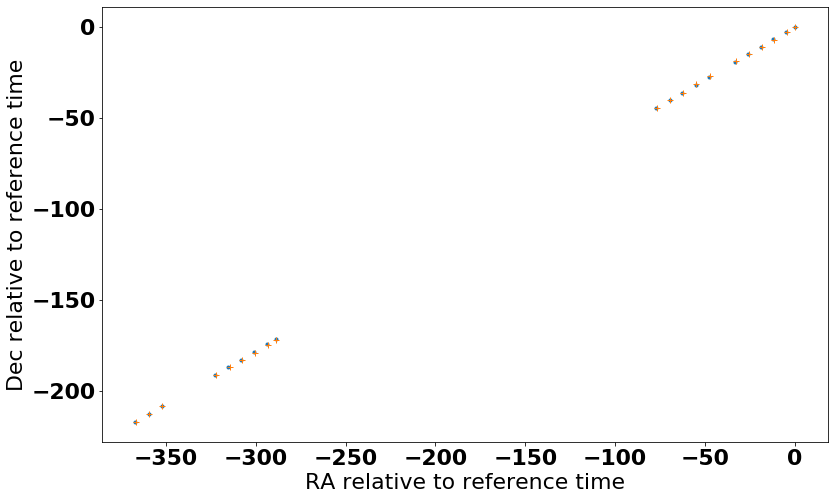

In [25]:
pix_from_abg=np.array(D.image_data.WCS[0].all_world2pix(radec_from_abg[0, :], radec_from_abg[1, :], 0))[::-1]
shifts_from_abg = pix_from_abg[:, 0] - pix_from_abg.T
shiftsi=(shifts-shifts[0])[[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,21,22,23]]
plt.plot(*shifts_from_abg.T, '.')
plt.plot(*shiftsi.T, '+')
plt.xlabel('RA relative to reference time')
plt.ylabel('Dec relative to reference time')

Text(0, 0.5, 'Residual (")')

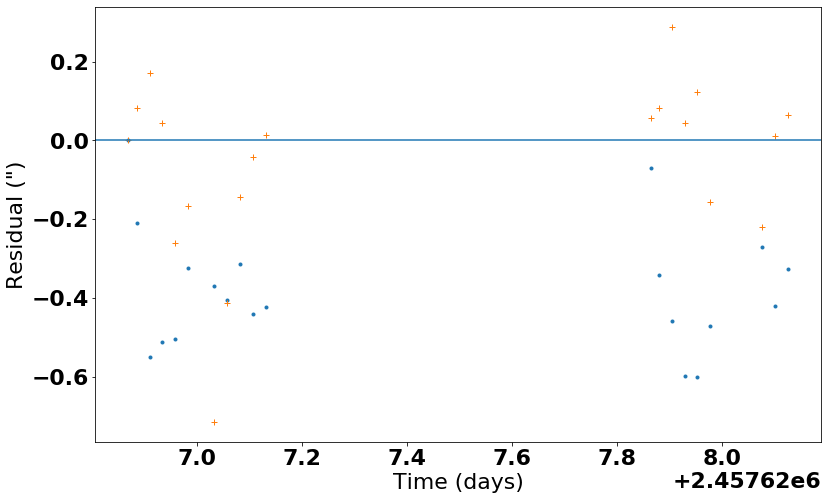

In [26]:
plt.plot(times_tst, (shifts_from_abg-shiftsi)[:,0], '.', label='RA residual (abg prediction - measured astrometry)')
plt.plot(times_tst, (shifts_from_abg-shiftsi)[:,1], '+', label='Dec residual (abg prediction - measured astrometry)')
plt.axhline(0)
plt.xlabel('Time (days)')
plt.ylabel('Residual (")')

### Just convert thetas to radec and use WCS to figure out pixel shift. 
Since it seems I can't figure out how to convert thetas directly to pixel shifts. 

In [27]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)

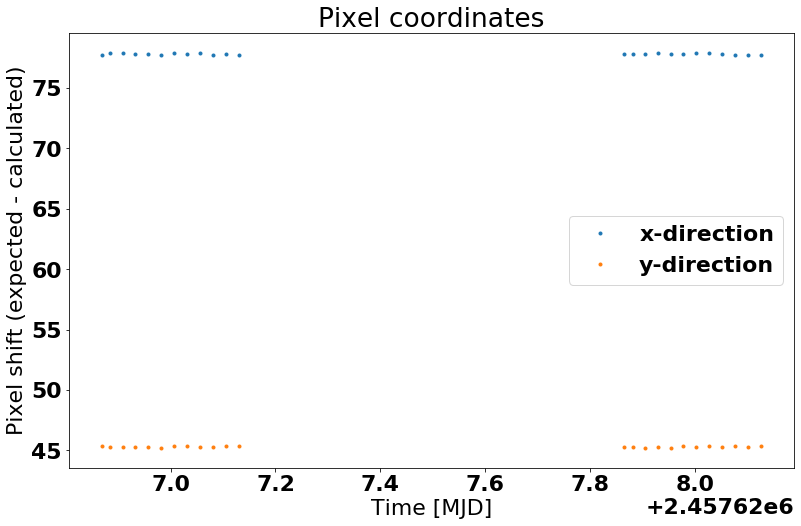

In [28]:
'''Shift+stack using the shift calculated from abg, using improved pixel scale & rotation.'''
'''
Get the position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec
# Convert to pixels
#thetas_pixels = thetas_asec / 0.170      # This could be more accurate, but is pretty close. 
#thetas_pixels = thetas_asec / pix_scale  #   based on calculation above

'''Convert to pixel shift'''
ec_from_abg = proj_to_ec(thetas[:, 0], thetas[:, 1], *latlon0)
radec_from_abg = np.degrees(ec_to_eq(*ec_from_abg))
pix_list = []
for i, wcsi in enumerate(D.image_data.WCS):
              pix_list.append(wcsi.all_world2pix(radec_from_abg[0, i], 
                                                 radec_from_abg[1, i], 0))
pix_from_abg = np.array(pix_list).T[::-1]
shifts_from_abg = pix_from_abg[:, 12] - pix_from_abg.T

'''Make nice plot'''

plt.plot(times, (shifts-shifts_from_abg)[:, 0], '.', label='x-direction')
plt.plot(times, (shifts-shifts_from_abg)[:, 1], '.', label='y-direction')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift (expected - calculated)')
plt.title('Pixel coordinates')
l=plt.legend()

Combining images using median stacking.


Peak count $\pm$ noise = 58.1 $\pm$  4.1 (14.3$\sigma$)

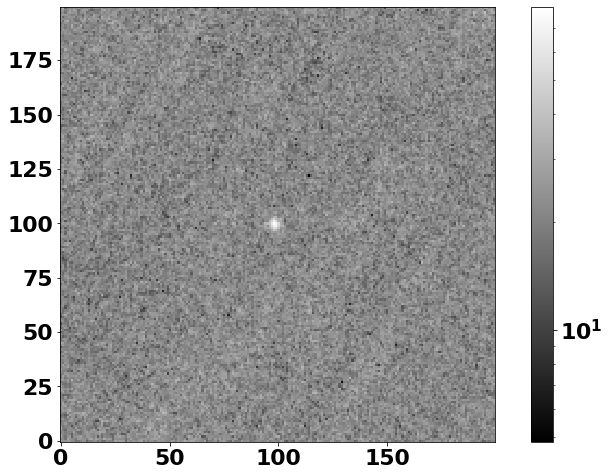

In [29]:
'''
Shift and stack using the calculated shifts.
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(shifts_from_abg, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[520:720,405:605]-np.nanmedian(D.stacked_data.data[520:720,405:605]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

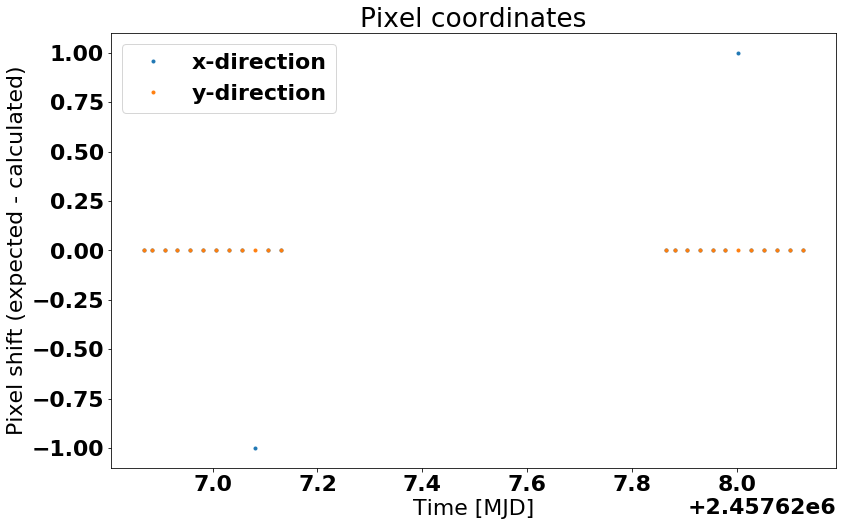

In [31]:
'''Make nice plot'''
plt.plot(times, (shifts.round(0).astype(int)-shifts_from_abg.round(0).astype(int))[:, 0], '.', label='x-direction')
plt.plot(times, (shifts.round(0).astype(int)-shifts_from_abg.round(0).astype(int))[:, 1], '.', label='y-direction')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift (expected - calculated)')
plt.title('Pixel coordinates')
l=plt.legend()

### Now use functionality built into transformer

In [32]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)

In [33]:
import transformer
importlib.reload(transformer)

<module 'transformer' from '/home/mikea/GitHub/shifty/shifty/transformer.py'>

In [34]:
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5
T=transformer.Transformer(times, '568', 'JPL')

In [35]:
shift_abg = T(abg, time0, latlon0, D.image_data.WCS)
print(shift_abg)

[[  0.           0.        ]
 [  4.5141798    2.69411882]
 [ 11.4381244    6.99033993]
 [ 18.39453112  10.94079721]
 [ 25.47828651  14.79229795]
 [ 32.70767182  18.9281288 ]
 [ 40.11769641  22.87300724]
 [ 47.40651394  27.04671472]
 [ 54.86473388  31.561916  ]
 [ 62.13597826  36.08828262]
 [ 69.25975831  40.46820079]
 [ 76.56000984  44.87559937]
 [288.90838107 171.66934162]
 [293.2834107  174.36773767]
 [300.48118128 178.7848246 ]
 [307.49862294 182.73047877]
 [314.62090357 186.88102308]
 [322.02372316 190.96207683]
 [329.27912366 194.83950099]
 [336.95275867 199.01170401]
 [344.50708872 203.57782665]
 [352.00260467 208.17250578]
 [359.11072296 212.56803413]
 [366.6528013  217.04029668]]


Combining images using median stacking.


Peak count $\pm$ noise = 58.1 $\pm$  4.1 (14.3$\sigma$)

Saving to file stack_abg.fits
Done!


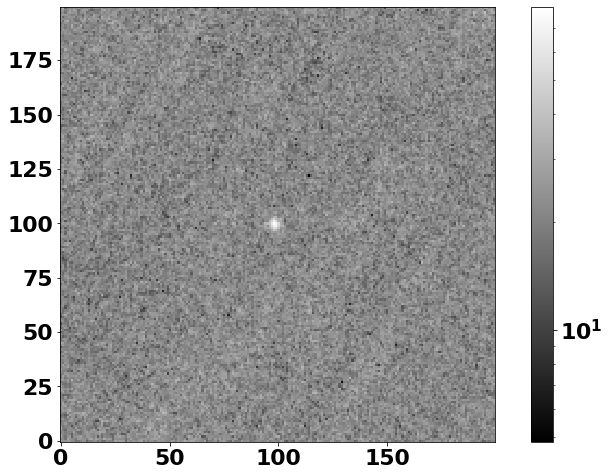

In [36]:
'''
Shift and stack using the calculated shifts.
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(-shift_abg, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[520:720,405:605]-np.nanmedian(D.stacked_data.data[520:720,405:605]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))
D.save_stack('stack_abg.fits')

Combining images using median stacking.
Combining images using median stacking.


Peak count $\pm$ noise = 58.1 $\pm$  3.5 (16.6$\sigma$)

Saving to file stack_abg.fits
Done!


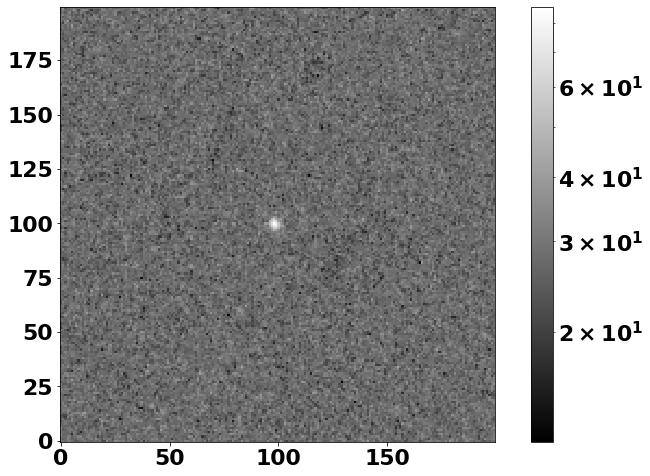

In [37]:
'''
Shift and stack using the calculated shifts.
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.stack(shifted=False, median_combine=True)
dmean = D.stacked_data.data
for i, d in enumerate(D.image_data.data):
    D.image_data.data[i] = d - dmean
D.integer_shift(-shift_abg, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[520:720,405:605]-np.nanmedian(D.stacked_data.data[520:720,405:605]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))
D.save_stack('stack_abg.fits')

In [38]:
print('print')

print
